# Part 2 - Python challenge

To analyze meteorological data, I first download and clean the data. For this purpose, I created a function that downloads a data file from http://opendata.dwd.de. As an argument, the function takes a url with a list of data files, the weather station ID and the path where the downloaded files will be saved and extracted.  
  
To accomplish this webscraping task, I use the BeautifulSoup and requests libraries.  
  
**Note:** There is no (currently) file named `stundenwerte_TU_03278_20090401_20211231_hist.zip` on the DWD website. There is only the file `stundenwerte_TU_03278_20090401_20221231_hist.zip`, which I suspect from the file name is more recent and the data range ends not on 2021-12-31, but a year longer on 2022-12-31. Therefore, in further analysis, I will use this file.


In [62]:
from bs4 import BeautifulSoup
import requests
import re
import zipfile
import os

url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/'
station_id = '03278' # Station ID for Metzingen station
path = 'data/'

def get_meteo_data(url, station_id, path):

    # using Beautiful Soup and requests to get all website HTML code
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # finding the exact filename based on station ID provided as an argument
    pattern = 'stundenwerte_TU_' + station_id
    filename = soup.find_all('a', text=re.compile(pattern))[0].text
    download_url = url + filename

    # file downloading 
    r = requests.get(download_url)
    with open((path + filename), 'wb') as f:
        f.write(r.content)
    print(filename + " " + str(r.status_code))

    # if file download is a success then unzip the file and remove remaining .zip file
    if r.status_code == 200:
        os.chdir(path)
        local_path = os.path.abspath(filename) 
        zip_ref = zipfile.ZipFile(local_path) 
        zip_ref.extractall() 
        zip_ref.close() 
        os.remove(filename)
        os.chdir('..')
        print(filename + ' unzipped!')
    else:
        print('Error: Cannot download the file: ' + filename)


get_meteo_data(url, station_id, path)


stundenwerte_TU_03278_20090401_20221231_hist.zip 200


First look at raw data.

In [17]:
import pandas as pd

raw_data = pd.read_csv('data/produkt_tu_stunde_20090401_20221231_03278.txt', delimiter=';')
raw_data.sample(10)

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
77223,3278,2018012115,3,3.2,65.0,eor
10894,3278,2010062822,3,20.2,68.0,eor
36112,3278,2013051416,3,19.9,40.0,eor
78277,3278,2018030613,3,8.5,60.0,eor
27598,3278,2012052422,3,14.5,84.0,eor
84616,3278,2018112516,3,6.1,77.0,eor
95182,3278,2020020822,3,1.1,90.0,eor
39487,3278,2013100207,3,7.2,94.0,eor
72965,3278,2017072805,3,15.0,93.0,eor
2746,3278,2009072410,3,22.8,49.0,eor


After data extraction, the next step is to transform and clean the data based on the given guidelines using pandas library.

In [7]:

filename = 'produkt_tu_stunde_20090401_20221231_03278.txt'

def data_transform(filename):
    file_path = 'data/' + filename
    df = pd.read_csv(file_path, delimiter=';')

    # leaving only relevant columns
    df = df[['MESS_DATUM', 'TT_TU', 'RF_TU']]

    # renaming columns 
    df = df.rename(columns={'MESS_DATUM':'date_time', 'TT_TU':'temp', 'RF_TU':'hum'})

    # dropping rows with missing values
    df = df[df['temp'] > -999]
    df = df[df['hum'] > -999]

    # changing data type in 'date_time' column into datetime format and setting datetime index
    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%d%H')
    df = df.set_index('date_time')

    # saving transformed data into new .csv file
    df.to_csv('data/meteo_data_cleaned.csv')

data_transform(filename)

Displaying transformed and cleaned data.

In [14]:
df = pd.read_csv('data/meteo_data_cleaned.csv', parse_dates= True, index_col='date_time')
df

,temp,hum
date_time,,
2009-04-01 00:00:00,4.3,81.0
2009-04-01 01:00:00,3.2,84.0
2009-04-01 02:00:00,2.2,88.0
2009-04-01 03:00:00,1.6,89.0
2009-04-01 04:00:00,1.2,92.0
...,...,...
2022-12-31 19:00:00,12.9,73.0
2022-12-31 20:00:00,10.9,81.0
2022-12-31 21:00:00,10.4,85.0


### Question 1

Compute the air distance to the Bosch plant located at (48.49524, 9.13782) using a suitable formula.

There were many files in the .zip package. One of them, `Metadaten_Geographie_03278.txt` contains metadata related to the geographical coordinates of the station in Metzingen (Station ID 3278). It turns out that the location of the station has changed over the years. According to this data, the current location is at the coordinates:  
**(48.5377, 9.2734)**

In [27]:
metadata = pd.read_csv('data/Metadaten_Geographie_03278.txt', delimiter=';')
metadata

,Stations_id,Stationshoehe,Geogr.Breite,Geogr.Laenge,von_datum,bis_datum,Stationsname
0,3278,350.0,48.5348,9.2889,19240620,19900331,Metzingen
1,3278,362.0,48.5318,9.2789,19900401,20021231,Metzingen
2,3278,370.0,48.5301,9.3161,20030101,20080610,Metzingen
3,3278,354.0,48.5377,9.2734,20081202,,Metzingen


To calculate the air distance between the weather station in Metzingen and the Bosch factory, I will use the python geopy library.

In [25]:
from geopy.distance import geodesic
from geopy.distance import great_circle

# geographical coordinates of weather station and factory
metzingen_station = (48.5377, 9.2734)
bosch_factory = (48.49524, 9.13782)

# calculating geodesic and great circle distance

print('Great circle distance:', round(great_circle(metzingen_station, bosch_factory).km,3), 'km')
print('Geodesic distance:', round(geodesic(metzingen_station, bosch_factory).km,3), 'km')



Great circle distance: 11.046 km
Geodesic distance: 11.073 km


**ANSWER:** The air distance between Metzingen station and Bosch factory is 11.046 km (great circle distance) or 11.073 km (geodesic distance)

### Question 2

Describe the general properties of the dataset. This could be, among others:
* number of samples, missing values, ...
* measures of central tendency
* measures of variability (or spread)
* correlation measures

Basic analysis of general dataset properties can be done using the pandas `info()` and `describe()` methods.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120472 entries, 2009-04-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    120472 non-null  float64
 1   hum     120472 non-null  float64
dtypes: float64(2)
memory usage: 2.8 MB


There are two columns in the dataset with temperature and humidity data. There are 120472 records in total with no missing values. The time range starts on 2009-04-01 and ends on 2022-12-31. The frequency of successive records is one hour (as also indicated by the name of the file).

In [34]:
df.describe()

,temp,hum
count,120472.000000,120472.000000
mean,10.934321,74.119322
std,8.225368,18.949373
min,-18.400000,11.000000
25%,4.700000,62.000000
50%,10.800000,79.000000
75%,16.800000,90.000000
max,37.100000,100.000000


Above is a table with all the basic statistical metrics such as: mean, minimum, maximum, median, standard deviation and quartiles. Below the mode for temperature and humidity is calculated:

In [41]:
print('Temperature mode: ',df['temp'].mode().values[0])
print('Humidity mode: ',df['hum'].mode().values[0])

Temperature mode:  11.9
Humidity mode:  94.0


Based on the above data, it can be concluded that the temperature has a very close median, mean and mode, which may indicate a possible normal distribution. Also for humidity, similar mean and median values can be observed. However, the mode is already 94.0 and the Q3 value is 90.0, which may indicate a larger spread of data and negative skewness.  
  
Data distribution is best visualized on a histogram:

[Text(0.5, 1.0, 'Temperature distribution'), Text(0.5, 0, 'temperature [*C]')]

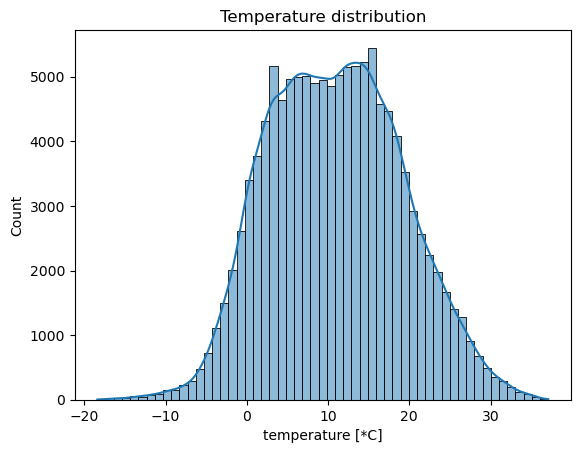

In [51]:
import seaborn as sns

sns.histplot(data=df['temp'], bins=55, kde=True).set(title='Temperature distribution', xlabel='temperature [*C]')


[Text(0.5, 1.0, 'Humidity distribution'), Text(0.5, 0, 'humidity [%]')]

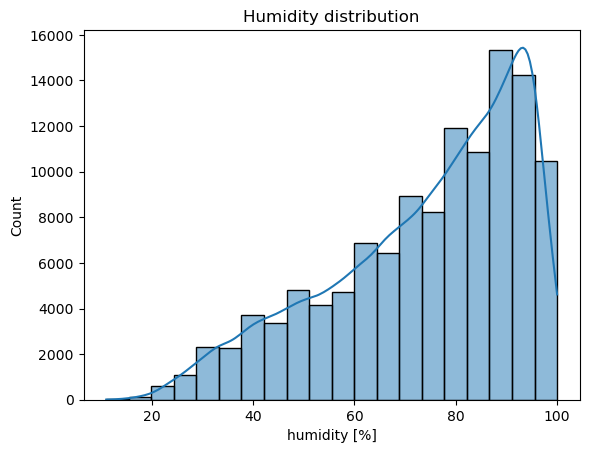

In [54]:
sns.histplot(data=df['hum'], bins=20, kde=True).set(title='Humidity distribution', xlabel='humidity [%]')

There are two columns of temperature and humidity in the dataset. Using the built-in pandas `corr()` method,  the correlation coefficient between these data can be obtained as well as visualization of the relationship between these data on a pairplot.

In [130]:
df.corr(method='pearson')

,temp,hum
temp,1.000000,-0.570033
hum,-0.570033,1.000000


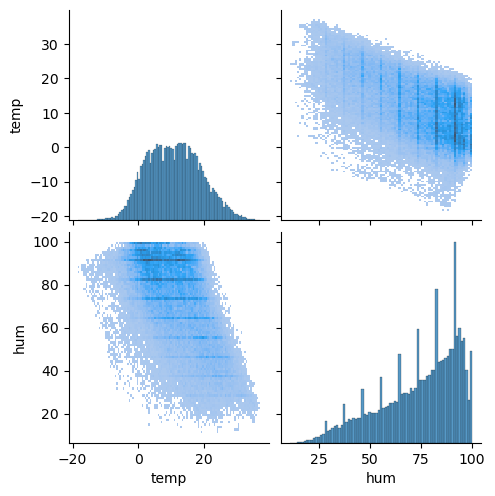

In [55]:
sns.pairplot(df, kind="hist")

Based on the results, a moderate negative correlation between temperature and humidity can be stated. Humidity decreases with increasing temperature.

Below is a chart with average temperature and humidity values calculated for each month. then the number of points on the plot decreases, which makes the correlation more visible.

In [59]:
# creating a temp df with monthly average of temperature and humidity

df_monthly_mean = df.resample("MS").mean()
df_monthly_mean.sample(5)

,temp,hum
date_time,,
2015-03-01,6.498790,68.556452
2015-12-01,5.869758,83.208333
2021-06-01,19.893889,68.416667
2017-01-01,-2.640323,80.612903
2014-03-01,8.031183,64.756720


[Text(0.5, 1.0, 'Temperature / Humidity correlation'),
 Text(0.5, 0, 'temperature[*C]'),
 Text(0, 0.5, 'humidity [%]')]

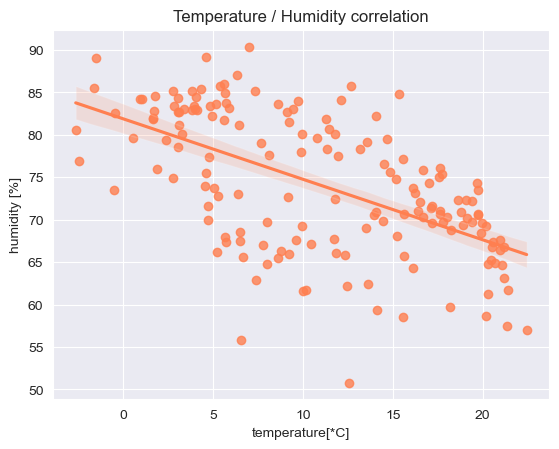

In [67]:
sns.set_style("darkgrid")
sns.regplot(data=df_monthly_mean, x='temp', y='hum', color="coral").set(title='Temperature / Humidity correlation', xlabel='temperature[*C]', ylabel='humidity [%]')

### Question 3 

Compute the minimum, maximum and average temperature in January 2017.

In [110]:
# creating a new temp dataframe containig only records from January 2017

january = df[(df.index.year == 2017) & (df.index.month == 1)]

In [118]:
print('Minimum temperature: ', round(january['temp'].min(),1))
print('Maximum temperature: ', round(january['temp'].max(),1))
print('Average temperature: ', round(january['temp'].mean(),1))

Minimum temperature:  -15.2
Maximum temperature:  8.8
Average temperature:  -2.6


**ANSWER:** In January 2017 there were following temperatures:
* Minimum: -15.2  
* Maximum: 8.8  
* Average: -2.6

### Question 4

Assess the temperature development in the data. Can you find signs of climate change? Perform aggregations, visualizations to show your findings.

<AxesSubplot:xlabel='date_time'>

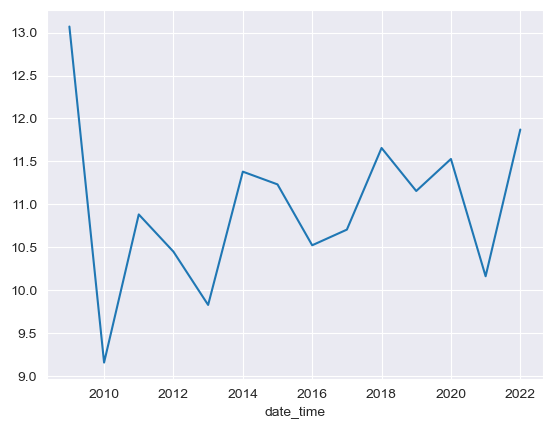

In [71]:
df.groupby(df.index.year)['temp'].mean().plot()

<AxesSubplot:xlabel='date_time'>

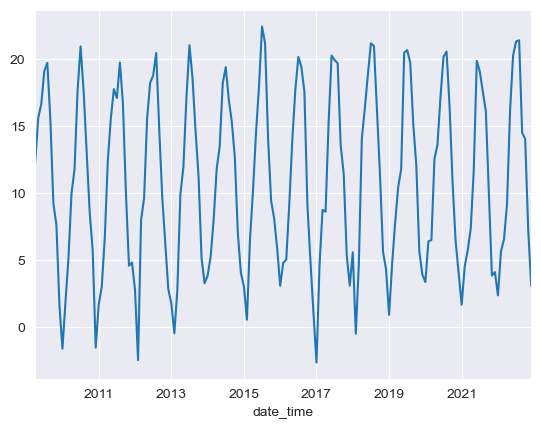

In [70]:
df_monthly_mean['temp'].plot()